<a href="https://colab.research.google.com/github/kuds/rl-atari-pong/blob/main/%5BAtari%20Pong%5D%20Single-Agent%20Reinforcement%20Learning%20PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Atari Pong] Single-Agent Reinforcement Learning PPO

In [1]:
!pip install swig

In [2]:
!pip install stable-baselines3

In [3]:
!pip install gymnasium[atari] ale-py

In [4]:
import os
import csv
import time
import json
import platform
import torch
import numpy
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import CallbackList
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.vec_env import VecVideoRecorder
from stable_baselines3.common.vec_env import VecTransposeImage
import matplotlib.pyplot
import matplotlib
import ale_py
import gymnasium
from importlib.metadata import version
from datetime import datetime
import google.colab.drive

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
if torch.cuda.is_available(): print(f"GPU Device: {torch.cuda.get_device_name(0)}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Scipy Version: {version('scipy')}")
print(f"Swig Version: {version('swig')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")
print(f"ALE Version: {version('ale_py')}")

Python Version: 3.12.12
Torch Version: 2.8.0+cu126
Is Cuda Available: True
Cuda Version: 12.6
GPU Device: NVIDIA L4
Gymnasium Version: 1.2.1
Numpy Version: 2.0.2
Scipy Version: 1.16.2
Swig Version: 4.3.1.post0
Stable Baselines3 Version: 2.7.0
ALE Version: 0.11.2


In [6]:
gdrive_path = "/content/gdrive"
google.colab.drive.mount(gdrive_path, force_remount=True)

Mounted at /content/gdrive


In [7]:
rl_type = "PPO"
env_str =  "PongNoFrameskip-v4" #"ALE/Pong-v5"
name_prefix = "atari_pong_ppo"
log_dir = ""
parent_path = ""
use_google_drive = True
if use_google_drive:
    parent_path = "/content/gdrive"
    google.colab.drive.mount(parent_path, force_remount=True)
    log_dir = "{}/MyDrive/Finding Theta/logs/{}/{}".format(parent_path,
                                                       env_str,
                                                       rl_type)
else:
    log_dir = "/content/logs/{}/{}".format(env_str, rl_type)

Mounted at /content/gdrive


In [8]:
training_data_path = os.path.join(log_dir, "training jobs")
time_folder = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
model_folder_path = os.path.join(log_dir, "training jobs", time_folder)

In [9]:
#Create Folders
os.makedirs(log_dir, exist_ok=True)
os.makedirs(training_data_path, exist_ok=True)
os.makedirs(model_folder_path, exist_ok=True)

In [10]:
env = make_atari_env(env_str, n_envs=1, seed=0)
print("Observation Space Size: ", env.observation_space.shape)
print('Actions Space: ', env.action_space)
env.close()

Observation Space Size:  (84, 84, 1)
Actions Space:  Discrete(6)


In [11]:
env = gymnasium.make(env_str)
print("Observation Space Size: ", env.observation_space.shape)
print('Actions Space: ', env.action_space)
env.close()

Observation Space Size:  (210, 160, 3)
Actions Space:  Discrete(6)


In [12]:
# Use Hyperparameters from RL Zoo
hyperparams = {
    "env_str": env_str,
    "rl_type": rl_type,
    "eval_freq": 50_000,
    "total_timesteps": 4_000_000,
    "clip_range": 0.1,
    "learning_rate": 2.5e-4,
    "n_steps": 128,
    "n_epochs": 4,
    "n_envs": 8,
    "batch_size": 256,
    "ent_coef": 0.01,
    "vf_coef": 0.5,
}

# https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/ppo.yml
# atari:
#   env_wrapper:
#     - stable_baselines3.common.atari_wrappers.AtariWrapper
#   frame_stack: 4
#   policy: 'CnnPolicy'
#   n_envs: 8
#   n_steps: 128
#   n_epochs: 4
#   batch_size: 256
#   n_timesteps: !!float 1e7
#   learning_rate: lin_2.5e-4
#   clip_range: lin_0.1
#   vf_coef: 0.5
#   ent_coef: 0.01

In [13]:
# Evaluation Environment Wrapper Arguments
# Disable Frame Skipping
# Disable Noop Max
# https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/
# https://stable-baselines3.readthedocs.io/en/master/common/atari_wrappers.html

# Training Aruguments
env_wrap_args = {"frame_skip": 4}
env_kwargs = {"render_mode": "rgb_array"}

# Evaluation Aruguments
env_val_wrap_args = {"frame_skip": 4, "noop_max": 30}
env_val_kwargs = {"render_mode": "rgb_array"}

if(env_str == "ALE/Pong-v5"):
  env_wrap_args["frame_skip"] = 0
  env_val_kwargs["frameskip"] = 32
  env_val_kwargs["repeat_action_probability"] = 0.0

In [14]:
with open(os.path.join(model_folder_path, 'parameters.json'), 'w') as fp:
    parameters = {"hyperparams": hyperparams,
                  "env_wrap_args": env_wrap_args,
                  "env_kwargs": env_kwargs,
                  "env_val_wrap_args": env_val_wrap_args,
                  "env_val_kwargs": env_val_kwargs}
    json.dump(parameters, fp, indent=4)

In [15]:
class VideoRecordCallback(BaseCallback):
    def __init__(
        self,
        save_path: str,
        video_length: int,
        save_freq: int = 5_000,
        name_prefix: str ="rl_model",
        verbose: int = 0):

        super().__init__(verbose)
        self.save_freq = save_freq
        self.video_length = video_length
        self.save_path = save_path
        self.name_prefix = name_prefix
        # Those variables will be accessible in the callback
        # (they are defined in the base class)
        # The RL model
        # self.model = None  # type: BaseAlgorithm
        # An alias for self.model.get_env(), the environment used for training
        # self.training_env # type: VecEnv
        # Number of time the callback was called
        # self.n_calls = 0  # type: int
        # num_timesteps = n_envs * n times env.step() was called
        # self.num_timesteps = 0  # type: int
        # local and global variables
        # self.locals = {}  # type: Dict[str, Any]
        # self.globals = {}  # type: Dict[str, Any]
        # The logger object, used to report things in the terminal
        # self.logger # type: stable_baselines3.common.logger.Logger
        # Sometimes, for event callback, it is useful
        # to have access to the parent object
        # self.parent = None  # type: Optional[BaseCallback]

    def _on_step(self) -> bool:
        if self.n_calls % self.save_freq == 0:

          name_prefix = f"{self.name_prefix}_{self.num_timesteps}"

          # Record video of the best model playing Atari's Environment
          rec_val = make_atari_env(
              env_str,
              n_envs=1,
              seed=1)
          rec_val = VecFrameStack(rec_val, n_stack=4)
          rec_val = VecTransposeImage(rec_val)
          rec_val = VecVideoRecorder(rec_val,
                                    self.save_path,
                                    video_length=self.video_length,
                                    record_video_trigger=lambda x: x == 0,
                                    name_prefix=name_prefix)

          obs = rec_val.reset()
          for _ in range(self.video_length):
              action, _states = self.model.predict(obs)
              obs, rewards, dones, info = rec_val.step(action)
              rec_val.render()
              if dones:
                break

          rec_val.close()
        return True

In [16]:
# Create the Training Atari's Pong environment with appropriate wrappers
env = make_atari_env(env_str,
                     n_envs=hyperparams["n_envs"],
                     seed=0,
                     monitor_dir=os.path.join(model_folder_path, "monitor"))
env = VecFrameStack(env, n_stack=4)
env = VecTransposeImage(env)

# Create the Evaluation Atari's Pong environment with appropriate wrappers
env_val = make_atari_env(env_str,
                         n_envs=1,
                         seed=1)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

In [17]:
# Create Callbacks
# Create Evaluation Callback
eval_callback = EvalCallback(
    env_val,
    best_model_save_path=model_folder_path,
    log_path=model_folder_path,
    eval_freq=hyperparams["eval_freq"],
    render=False,
    deterministic=True,
    n_eval_episodes=5)

# Create Checkpoint Callback
checkpoint_callback = CheckpointCallback(
    save_freq=hyperparams["eval_freq"],
    save_path=os.path.join(model_folder_path, "checkpoints"),
    name_prefix=name_prefix,
    save_replay_buffer=False,
    save_vecnormalize=False,
)

video_record_callback = VideoRecordCallback(
    save_path=os.path.join(model_folder_path, "videos"),
    video_length=10_000,
    save_freq=hyperparams["eval_freq"],
    name_prefix=name_prefix)

# Create the callback list
callbackList = CallbackList([checkpoint_callback,
                             video_record_callback,
                             eval_callback])

In [18]:
# Initialize PPO
model = PPO('CnnPolicy',
            env,
            verbose=0,
            batch_size=hyperparams["batch_size"],
            learning_rate=hyperparams["learning_rate"],
            clip_range=hyperparams["clip_range"],
            n_steps=hyperparams["n_steps"],
            n_epochs=hyperparams["n_epochs"],
            tensorboard_log=os.path.join(log_dir, "tensorboard"))

# Train the model
model.learn(total_timesteps=hyperparams["total_timesteps"],
            progress_bar=False,
            callback=callbackList)

# Save the trained model
model.save(os.path.join(model_folder_path, "final_model"))

env.close()
env_val.close()

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


Moviepy - Building video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_400000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_400000-step-0-to-step-10000.mp4



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_400000-step-0-to-step-10000.mp4
Eval num_timesteps=400000, episode_reward=-21.00 +/- 0.00
Episode length: 3056.00 +/- 0.00
New best mean reward!
Moviepy - Building video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_800000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_800000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_800000-step-0-to-step-10000.mp4
Eval num_timesteps=800000, episode_reward=7.80 +/- 4.40
Episode length: 11417.40 +/- 132.80
New best mean reward!
Moviepy - Building video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_1200000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_1200000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_1200000-step-0-to-step-10000.mp4
Eval num_timesteps=1200000, episode_reward=11.60 +/- 3.88
Episode length: 8388.60 +/- 651.41
New best mean reward!
Moviepy - Building video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_1600000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_1600000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_1600000-step-0-to-step-10000.mp4
Eval num_timesteps=1600000, episode_reward=16.40 +/- 3.67
Episode length: 7949.80 +/- 962.90
New best mean reward!
Moviepy - Building video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_2000000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_2000000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_2000000-step-0-to-step-10000.mp4
Eval num_timesteps=2000000, episode_reward=17.80 +/- 3.66
Episode length: 9351.80 +/- 2906.68
New best mean reward!
Moviepy - Building video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_2400000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_2400000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_2400000-step-0-to-step-10000.mp4
Eval num_timesteps=2400000, episode_reward=14.20 +/- 5.08
Episode length: 11175.80 +/- 3364.54
Moviepy - Building video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_2800000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_2800000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_2800000-step-0-to-step-10000.mp4
Eval num_timesteps=2800000, episode_reward=20.60 +/- 0.49
Episode length: 7937.60 +/- 1864.16
New best mean reward!
Moviepy - Building video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_3200000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_3200000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_3200000-step-0-to-step-10000.mp4
Eval num_timesteps=3200000, episode_reward=20.40 +/- 0.49
Episode length: 10224.00 +/- 3784.10
Moviepy - Building video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_3600000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_3600000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_3600000-step-0-to-step-10000.mp4
Eval num_timesteps=3600000, episode_reward=20.60 +/- 0.49
Episode length: 9766.80 +/- 2209.03
Moviepy - Building video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_4000000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_4000000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/atari_pong_ppo_4000000-step-0-to-step-10000.mp4
Eval num_timesteps=4000000, episode_reward=20.20 +/- 1.17
Episode length: 11983.20 +/- 3843.97


In [19]:
# # Get model path from last training job (uncomment if training job interrupted)
# # List all entries in the directory
# entries = os.listdir(training_data_path)

# # Filter out only directories
# folders = [entry for entry in entries if os.path.isdir(os.path.join(training_data_path, entry))]

# # Sort the folders alphabetically
# folders.sort()

# # Get the last folder
# model_folder_path = os.path.join(training_data_path, folders[-1])
# print(model_folder_path)

In [20]:
# Create the Evaluation Atari's Pong environment with appropriate wrappers
env_val = make_atari_env(env_str,
                         n_envs=1,
                         seed=1)
env_val = VecFrameStack(env_val, n_stack=4)
env_val = VecTransposeImage(env_val)

# Load the best model
best_model_path = os.path.join(model_folder_path, "best_model")
best_model = PPO.load(best_model_path, env=env_val)

mean_reward, std_reward = evaluate_policy(
    best_model,
    env_val,
    n_eval_episodes=5)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

best_metrics_path = os.path.join(log_dir, "best_model_metrics.csv")

# Create Best Model Metrics file if not there
if(not os.path.isfile(best_metrics_path)):
  with open(best_metrics_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["run_date",
                     "batch_size",
                     "ent_coef",
                     "learning_rate",
                     "num_timesteps",
                     "mean_reward",
                     "std_reward",
                     "n_steps",
                     "n_envs",
                     "gamma",
                     "gae_lambda",
                     "clip_range_vf",
                     "n_epochs"])

new_data = [os.path.basename(os.path.normpath(model_folder_path)),
            best_model.batch_size,
            best_model.ent_coef,
            best_model.learning_rate,
            best_model.num_timesteps,
            mean_reward,
            std_reward,
            best_model.n_steps,
            best_model.n_envs,
            best_model.gamma,
            best_model.gae_lambda,
            best_model.clip_range_vf,
            best_model.n_epochs]

with open(best_metrics_path, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(new_data)

# Record video of the best model playing Atari's Pong
best_model_file_name = "best_model_{}".format(name_prefix)
rec_val = VecVideoRecorder(env_val,
                           os.path.join(model_folder_path, "videos"),
                           video_length=10_000,
                           record_video_trigger=lambda x: x == 0,
                           name_prefix=best_model_file_name)

obs = rec_val.reset()
for _ in range(10_000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = rec_val.step(action)
    rec_val.render()
    if dones:
      break

env_val.close()
rec_val.close()

Best Model - Mean reward: 21.00 +/- 0.00
Moviepy - Building video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/best_model_atari_pong_ppo-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/best_model_atari_pong_ppo-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Finding Theta/logs/PongNoFrameskip-v4/PPO/training jobs/2025-10-17 00:10:03/videos/best_model_atari_pong_ppo-step-0-to-step-10000.mp4


In [21]:
# Print Model
print(best_model.policy)

ActorCriticCnnPolicy(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (vf_features_extractor): NatureCNN(
    (cnn): 

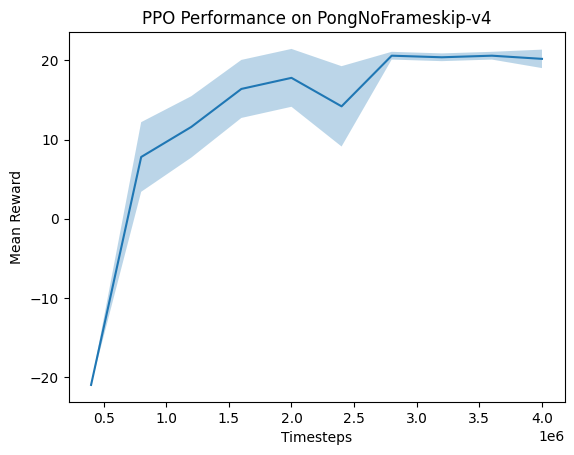

In [22]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(model_folder_path, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"{rl_type} Performance on {env_str}")
matplotlib.pyplot.savefig(os.path.join(model_folder_path, f"{rl_type}_{env_str}_performance.png"))
matplotlib.pyplot.show()